In [1]:
#import modules
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.snowball import FrenchStemmer
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from gensim import matutils, models
import scipy.sparse
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import warnings
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
warnings.simplefilter(action='ignore')
%matplotlib inline

stemmer = FrenchStemmer()
tokenizer = nltk.RegexpTokenizer(r'\w+')
stop_fr = nltk.corpus.stopwords.words('french')
stop_uk = nltk.corpus.stopwords.words('english')
stop_spacy_fr = list(fr_stop)

### 1. Import the scraped data from indeed website

In [2]:
df = pd.read_csv("data_full.csv",na_values = 'None')
df2 = pd.read_csv("devops_withoutDouble.csv",na_values = 'None')
df3 =  pd.read_csv("software+engineer.csv",na_values = 'None')
df4 = pd.read_csv('more_data.csv', na_values = 'None')

In [3]:
df = pd.concat([df, df2, df3, df4])
df = df[~df.duplicated(keep='first')] 
df.shape

(6889, 9)

### 2.  Salary

###### Get the rows which their salary value not NAN

In [4]:
# only with salary data present
df_salary = df.dropna(subset=['Salary'])
df_salary.shape

(786, 9)

In [5]:
# rest of the dataframe without salary info
df = df[~df.Salary.isin(df_salary.Salary)]
df.shape

(6103, 9)

##### Remove non numeric chars from salary

In [6]:
df_salary["Salary"] = df_salary["Salary"].str.replace("\n", "")
df_salary["Salary"] = df_salary["Salary"].str.replace(",", "")
df_salary["Salary"] = df_salary["Salary"].str.replace("€", "")
df_salary["Salary"] = df_salary["Salary"].str.replace("\xa0", "")
df_salary.head(2)

,Title,Location,Date,Company,Rating,Count,Salary,Contract,Description
2,Business Developer – Expert sécurité,Arras (62),il y a 18 jours,Uptoo,"4,5",32 avis,27000 - 55000 par an,27 000 € - 55 000 € par an,À PROPOS :Bienvenue dans notre PME spécialiste...
4,Manager Big Data H/F,Paris (75),Il y a plus de 30 jours,Elitegroup Recruitment,NaN,NaN,55000 - 75000 par an,"Temps plein, CDI",Présentation de l'entreprise:Notre client est ...


###### Extract the deffirent types of salary 

In [7]:
year_salaries = df_salary[df_salary["Salary"].str.contains("an")]
month_salaries = df_salary[df_salary["Salary"].str.contains("mois")]
day_salaries = df_salary[df_salary["Salary"].str.contains("jour")]
hour_salaries = df_salary[df_salary["Salary"].str.contains("heure")]

In [8]:
print(year_salaries.shape)
print(month_salaries.shape)
print(day_salaries.shape)
print(hour_salaries.shape)

(626, 9)
(97, 9)
(49, 9)
(14, 9)


In [9]:
# removing string values("par an", " par mois", etc. from salary dfs)

year_salaries["Salary"] = year_salaries["Salary"].str.replace(" par an", "")
month_salaries["Salary"] = month_salaries["Salary"].str.replace(" par mois", "")
day_salaries["Salary"] = day_salaries["Salary"].str.replace(" par jour", "")
hour_salaries["Salary"] = hour_salaries["Salary"].str.replace(" par heure", "")

###### Functions to get the average salary (avg_sal), the minimum declared value of salary (min_sal), and the maximum declared value of salary (max_sal)

In [10]:
def avg_sal(sal):
    try:
        splt = sal.split(' - ', 1)
        first = float(splt[0])
        second = float(splt[1])
        return (first + second)/2
    except:
        return float(sal)

In [11]:
def min_sal(sal):
    try:
        splt = sal.split(' - ', 1)
        first = float(splt[0])
        return first
    except:
        return float(sal)

In [12]:
def max_sal(sal):
    try:
        splt = sal.split(' - ', 1)
        second = float(splt[1])
        return second
    except:
        return float(sal)

###### Apply the defined functions on the different types of salary 

In [13]:
# min salary

year_salaries["min_salary"] = year_salaries["Salary"].apply(min_sal)
month_salaries["min_salary"] = month_salaries["Salary"].apply(min_sal)
day_salaries["min_salary"] = day_salaries["Salary"].apply(min_sal)
hour_salaries["min_salary"] = hour_salaries["Salary"].apply(min_sal)

In [14]:
# max salary

year_salaries["max_salary"] = year_salaries["Salary"].apply(max_sal)
month_salaries["max_salary"] = month_salaries["Salary"].apply(max_sal)
day_salaries["max_salary"] = day_salaries["Salary"].apply(max_sal)
hour_salaries["max_salary"] = hour_salaries["Salary"].apply(max_sal)

In [15]:
# average salary

year_salaries["avg_salary"] = year_salaries["Salary"].apply(avg_sal)
month_salaries["avg_salary"] = month_salaries["Salary"].apply(avg_sal)
day_salaries["avg_salary"] = day_salaries["Salary"].apply(avg_sal)
hour_salaries["avg_salary"] = hour_salaries["Salary"].apply(avg_sal)

In [16]:
# converting to yearly salary

month_salaries["min_salary"] = month_salaries["min_salary"] * 12
day_salaries["min_salary"] = day_salaries["min_salary"] * 230
hour_salaries["min_salary"] = hour_salaries["min_salary"] * 1607

In [17]:
month_salaries["max_salary"] = month_salaries["max_salary"] * 12
day_salaries["max_salary"] = day_salaries["max_salary"] * 230
hour_salaries["max_salary"] = hour_salaries["max_salary"] * 1607

In [18]:
month_salaries["avg_salary"] = month_salaries["avg_salary"] * 12
day_salaries["avg_salary"] = day_salaries["avg_salary"] * 230
hour_salaries["avg_salary"] = hour_salaries["avg_salary"] * 1607

In [19]:
month_salaries.head(2)

,Title,Location,Date,Company,Rating,Count,Salary,Contract,Description,min_salary,max_salary,avg_salary
9,Consultant business intelligence : BI / BO (F/H),Paris (75),Il y a plus de 30 jours,Elitech Conseil,NaN,NaN,2900 - 3400,"Temps plein, CDI",Elitech recrute en urgence !Un Consultant busi...,34800.0,40800.0,37800.0
323,ALTERNANCE - Assistant business analyste (H/F),Saint-Ouen (93),il y a 2 jours,OCP REPARTITION,NaN,NaN,924 - 1700,"Temps plein, Apprentissage","OCP, au cœur de la chaine de santéAu service d...",11088.0,20400.0,15744.0


###### Put all the salary dataframes together

In [20]:
df_salary = pd.concat([year_salaries, month_salaries, day_salaries, hour_salaries], sort=False)

In [21]:
df_salary.shape

(786, 12)

In [22]:
#rejoining salary data into main scrape_data df
df = pd.concat([df, df_salary])
df.shape

(6889, 12)

In [23]:
df.drop('Salary',axis=1,inplace=True)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6889 entries, 0 to 1146
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Title        6889 non-null   object 
 1   Location     6889 non-null   object 
 2   Date         6889 non-null   object 
 3   Company      6888 non-null   object 
 4   Rating       3614 non-null   object 
 5   Count        3541 non-null   object 
 6   Contract     4259 non-null   object 
 7   Description  6859 non-null   object 
 8   min_salary   786 non-null    float64
 9   max_salary   786 non-null    float64
 10  avg_salary   786 non-null    float64
dtypes: float64(3), object(8)
memory usage: 645.8+ KB


## Date

In [25]:
# count the number of date that contains the word 'jour'
df['Date'].str.contains("jour").mean()*100

99.81129336623603

In [26]:
# parsing date and extract the date in which the job offer has been published
from datetime import datetime, timedelta

def parse_date(date):   
    try:
        N = int(''.join(filter(lambda x: x.isdigit(), date)))
        date_N_days_ago = datetime.now() - timedelta(days=N)
        date_N_days_ago = date_N_days_ago.strftime('%Y-%m-%d')
        return date_N_days_ago
    except:
        pass 

In [27]:
df['Date'] = df['Date'].apply(parse_date)
df['Date'] = df['Date'].fillna(value=datetime.now().strftime('%Y-%m-%d'))
df.isna().mean()

Title          0.000000
Location       0.000000
Date           0.000000
Company        0.000145
Rating         0.475396
Count          0.485992
Contract       0.381768
Description    0.004355
min_salary     0.885905
max_salary     0.885905
avg_salary     0.885905
dtype: float64

In [28]:
df['Date'].head(2)

0    2020-04-30
1    2020-04-30
Name: Date, dtype: object

###### Extract the department from location, then delete it from location column

In [29]:
# extract department numbers in location
df['Dept']=df['Location'].str.extract('(\d+)')

In [30]:
# deal with NAN values
df['Dept'] = df['Dept'].fillna(0)
df['Dept']=df['Dept'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6889 entries, 0 to 1146
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Title        6889 non-null   object 
 1   Location     6889 non-null   object 
 2   Date         6889 non-null   object 
 3   Company      6888 non-null   object 
 4   Rating       3614 non-null   object 
 5   Count        3541 non-null   object 
 6   Contract     4259 non-null   object 
 7   Description  6859 non-null   object 
 8   min_salary   786 non-null    float64
 9   max_salary   786 non-null    float64
 10  avg_salary   786 non-null    float64
 11  Dept         6889 non-null   int64  
dtypes: float64(3), int64(1), object(8)
memory usage: 699.7+ KB


In [31]:
df['Location'] = df['Location'].str.replace(r"\(.*\)","")

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6889 entries, 0 to 1146
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Title        6889 non-null   object 
 1   Location     6889 non-null   object 
 2   Date         6889 non-null   object 
 3   Company      6888 non-null   object 
 4   Rating       3614 non-null   object 
 5   Count        3541 non-null   object 
 6   Contract     4259 non-null   object 
 7   Description  6859 non-null   object 
 8   min_salary   786 non-null    float64
 9   max_salary   786 non-null    float64
 10  avg_salary   786 non-null    float64
 11  Dept         6889 non-null   int64  
dtypes: float64(3), int64(1), object(8)
memory usage: 699.7+ KB


###### Extract BagOfWords from title and summary column and save them in a new columns

In [33]:
import spacy
from spacy import displacy
import nltk
from nltk.stem.snowball import SnowballStemmer

from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop

stemmer = SnowballStemmer(language='english')
tokenizer = nltk.RegexpTokenizer(r'\w+')
stop_fr  = nltk.corpus.stopwords.words('french')
stop_uk  = nltk.corpus.stopwords.words('english')
stop_spacy_fr=list(fr_stop)

In [34]:
def parse_text(x,location):
    text=str(x)
    # tokenize the text
    text = tokenizer.tokenize(text.lower())
    # delete english and frensh stop words
    text = [word for word in text if not word in stop_fr]
    text = [word for word in text if not word in stop_uk]
    text = [word for word in text if not word in stop_spacy_fr]
    # delete not wanted chars/words
    text = [word for word in text if word !=location.lower()]
    # delete not chars
    text=[word for word in text if word.isalpha()]
    # keep words with length more than 2 chars
    text=[word for word in text if len(word)>2]
    
    return text

In [35]:
df['title_words'] = df.apply(lambda x: parse_text(x.Title,x.Location), axis=1)

In [36]:
df['summary_words'] = df.apply(lambda x: parse_text(x.Description,x.Location), axis=1)

In [37]:
df.head(2)

,Title,Location,Date,Company,Rating,Count,Contract,Description,min_salary,max_salary,avg_salary,Dept,title_words,summary_words
0,Responsable Business Intelligence (BI) H/F,Benfeld,2020-04-30,Socomec,"3,7",32 avis,CDI,Référence de l'annonce : H-SSA-2019-59QUI SOMM...,NaN,NaN,NaN,67,"[responsable, business, intelligence]","[référence, annonce, ssa, courant, vital, lumi..."
1,Data Analyst - Business Intelligence H/F,Asnières-sur-Seine,2020-04-30,BCA Expertise,NaN,NaN,NaN,"Leader français de l'expertise automobile, BCA...",NaN,NaN,NaN,92,"[data, analyst, business, intelligence]","[leader, français, expertise, automobile, bca,..."


### Get the number of opinions from the count column

In [38]:
df.Count=df.Count.str.extract('(\d+)')

In [39]:
df.head(2)

,Title,Location,Date,Company,Rating,Count,Contract,Description,min_salary,max_salary,avg_salary,Dept,title_words,summary_words
0,Responsable Business Intelligence (BI) H/F,Benfeld,2020-04-30,Socomec,"3,7",32,CDI,Référence de l'annonce : H-SSA-2019-59QUI SOMM...,NaN,NaN,NaN,67,"[responsable, business, intelligence]","[référence, annonce, ssa, courant, vital, lumi..."
1,Data Analyst - Business Intelligence H/F,Asnières-sur-Seine,2020-04-30,BCA Expertise,NaN,NaN,NaN,"Leader français de l'expertise automobile, BCA...",NaN,NaN,NaN,92,"[data, analyst, business, intelligence]","[leader, français, expertise, automobile, bca,..."


### Get unique job offers from contract 

In [40]:
# delete salary from Contract column
import re
df.Contract = df.Contract.replace(re.compile('^[0-9]'), np.nan, regex=True)

In [41]:
print( len(df.Contract.unique()))

51


In [42]:
# define a dictionary with the most commun job types
dic = {'CDI': ['cdi'], 'CDD': ['cdd', 'stage', 'apprentissage', 'contrat pro', 'intérim'], 'Freelance': ['freelance', 'indépendant'],
       'Temps partiel': ['temps', 'partiel'], 'Temps plein': ['temps', 'plein'], 'Unknown': ['nan']}
dic

{'CDI': ['cdi'],
 'CDD': ['cdd', 'stage', 'apprentissage', 'contrat pro', 'intérim'],
 'Freelance': ['freelance', 'indépendant'],
 'Temps partiel': ['temps', 'partiel'],
 'Temps plein': ['temps', 'plein'],
 'Unknown': ['nan']}

In [43]:
def parseContract(x):
    text=str(x)
    # tokenize the text
    text = tokenizer.tokenize(text.lower())
    # delete not chars
    text=[word for word in text if word.isalpha()]
    # keep words with length more than 2 chars
    text=[word for word in text if len(word)>2]
    return text

In [44]:
df['contractWords']= df.apply(lambda x: parseContract(x.Contract), axis=1)
df['contractWords'].head(5)

0    [cdi]
1    [nan]
3    [cdi]
5    [cdi]
6    [cdi]
Name: contractWords, dtype: object

In [45]:
def FindJobType(x, desc):
    ''' input : contract type / job description
        search for correct job type'''
    # verify if the job type is cdi / temps plein / temps partiel / unknown type
    if len(desc)<=2:
        # check if the job type is included in desc
        if all(item in x for item in desc):
            return 1
        else:
            return 0
    # if the job type is cdd, then we verify that there is at least one description of it in the contract
    elif any(w in desc for w in x):
        return 1
    else: return 0

In [46]:
# example
FindJobType(['pro','temps','partiel'],['temps','partiel'])

1

In [47]:
# This function creates five columns in the dataframe df (keys in dictionary Dec), and assign the value 1 (exist) or 0 if not in the column contract
def DummyJobType(df,Dic):
    for Jtype, desc in Dic.items():
        for index ,row in df.iterrows():
            df.at[index, Jtype]=FindJobType(row['contractWords'],desc)
    return df 

In [48]:
df=DummyJobType(df,dic)

In [49]:
df.head(2)

,Title,Location,Date,Company,Rating,Count,Contract,Description,min_salary,max_salary,avg_salary,Dept,title_words,summary_words,contractWords,CDI,CDD,Freelance,Temps partiel,Temps plein,Unknown
0,Responsable Business Intelligence (BI) H/F,Benfeld,2020-04-30,Socomec,"3,7",32,CDI,Référence de l'annonce : H-SSA-2019-59QUI SOMM...,NaN,NaN,NaN,67,"[responsable, business, intelligence]","[référence, annonce, ssa, courant, vital, lumi...",[cdi],0.0,0.0,0.0,0.0,0.0,1.0
1,Data Analyst - Business Intelligence H/F,Asnières-sur-Seine,2020-04-30,BCA Expertise,NaN,NaN,NaN,"Leader français de l'expertise automobile, BCA...",NaN,NaN,NaN,92,"[data, analyst, business, intelligence]","[leader, français, expertise, automobile, bca,...",[nan],1.0,0.0,0.0,0.0,1.0,0.0


### Extract the most commun n-gram from job title

In [50]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = stop_fr).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [51]:
df['title_words']=df['title_words'].apply(lambda x: " ".join(x))

In [52]:
df.columns

Index(['Title', 'Location', 'Date', 'Company', 'Rating', 'Count', 'Contract', 'Description', 'min_salary', 'max_salary', 'avg_salary', 'Dept', 'title_words', 'summary_words', 'contractWords', 'CDI', 'CDD', 'Freelance', 'Temps partiel', 'Temps plein', 'Unknown'], dtype='object')

In [53]:
common_words = get_top_n_words(df['title_words'], 20)
for word, freq in common_words:
    print(word, freq)

data 1668
engineer 1212
développeur 891
ingénieur 837
devops 759
consultant 627
analyst 474
architecte 390
senior 388
software 355
web 318
scientist 316
business 308
cloud 293
big 280
java 263
manager 260
end 235
développement 231
stage 225


### Dealing with NaNs

Description and Company have very few missing values so we decide to drop rows. For Rating, we fill with the neutral rating of 3, and for Count, the obvious choixe is 0.

In [54]:
df.dropna(subset=['Description', 'Company'], inplace=True)

In [55]:
df['Rating'].fillna(3, inplace=True)

In [56]:
df['Count'].fillna(0, inplace=True)

In [57]:
df['Contract'].fillna('Non renseigné', inplace=True)

In [58]:
df.isna().mean()

Title            0.000000
Location         0.000000
Date             0.000000
Company          0.000000
Rating           0.000000
Count            0.000000
Contract         0.000000
Description      0.000000
min_salary       0.886556
max_salary       0.886556
avg_salary       0.886556
Dept             0.000000
title_words      0.000000
summary_words    0.000000
contractWords    0.000000
CDI              0.000000
CDD              0.000000
Freelance        0.000000
Temps partiel    0.000000
Temps plein      0.000000
Unknown          0.000000
dtype: float64

## Outliers

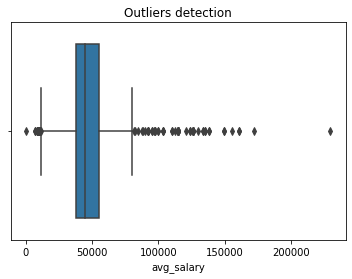

In [59]:
import seaborn as sns
sns.boxplot(x=df['avg_salary'])
plt.title('Outliers detection');

Removing that obvious outlier to help the model generalize better

### Location features

In [72]:
from geopy.geocoders import Nominatim
import pandas as pd

geolocator = Nominatim(user_agent='BANFrance')

df['geocode'] = df['Location'].apply(
    lambda x: geolocator.geocode(x, country_codes='FR', timeout=10))

In [73]:
df['lat-long'] = df['geocode'].apply(lambda x: tuple(x.point) if x else None)

In [74]:
df['lat-long'] = df['lat-long'].apply(lambda x: x[:-1] if x else None)

In [75]:
position = pd.DataFrame(df['lat-long'].tolist(), columns=['lat','long'], index=df['lat-long'].index)

In [76]:
df.reset_index(drop=True, inplace=True)
position.reset_index(drop=True, inplace=True)
df = pd.concat([df, position], axis=1)

In [77]:
# creating an extra feature to orient the model focus
df['lat*long'] = df['lat']*df['long']

## Regions feature

In [78]:
REGIONS = {
    'Auvergne-Rhône-Alpes': [1, 3, 7, 15, 26, 38, 42, 43, 63, 69, 73, 74],
    'Bourgogne-Franche-Comté': [21, 25, 39, 58, 70, 71, 89, 90],
    'Bretagne': [35, 22, 56, 29],
    'Centre-Val de Loire': [18, 28, 36, 37, 41, 45],
    'Corse': [2],
    'Grand Est': [8, 10, 51, 52, 54, 55, 57, 67, 68, 88],
    'Dom': [971, 972, 973, 974],
    'Hauts-de-France': [2, 59, 60, 62, 80],
    'Île-de-France': [75, 77, 78, 91, 92, 93, 94, 95],
    'Normandie': [14, 27, 50, 61, 76],
    'Nouvelle-Aquitaine': [16, 17, 19, 23, 24, 33, 40, 47, 64, 79, 86, 87],
    'Occitanie': [9, 11, 12, 30, 31, 32, 34, 46, 48, 65, 66, 81, 82],
    'Pays de la Loire': [44, 49, 53, 72, 85],
    "Provence-Alpes-Côte d'Azur": [4, 5, 6, 13, 83, 84]
}

In [79]:
regions = {}
for k, v in REGIONS.items():
    for x in v:
        regions[x] = k 

In [80]:
# creating the region feature thanks to the regions dict and dept column
df['Regions'] = 0
for i, dept in enumerate(df['Dept']):
    for k, v in regions.items():
        if dept == k:
            df['Regions'][i] = v

In [81]:
df['Regions']

0             Grand Est
1         Île-de-France
2       Hauts-de-France
3         Île-de-France
4             Occitanie
             ...       
6853          Occitanie
6854      Île-de-France
6855      Île-de-France
6856    Hauts-de-France
6857      Île-de-France
Name: Regions, Length: 6858, dtype: object

## Spliting and saving dataframes

In [82]:
df_nan = df[df['avg_salary'].isna()]
df_salary = df[~df.isin(df_nan)].dropna(how='all')
df_salary.shape

(778, 27)

In [83]:
df_salary = df_salary[df_salary['avg_salary'].astype(int) < 200000]

In [84]:
df_salary.to_csv('DATA_WITH_SALARY.csv', index=False)
df_nan.to_csv('DATA_WITHOUT_SALARY.csv', index=False)

In [85]:
df = pd.concat([df_salary, df_nan])

In [86]:
df.to_csv('DATA_FULL.csv', index=False)